In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [8]:
df = pd.read_csv(r"C:\Users\manee\Downloads\archive (20)\train.csv")

In [9]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [11]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format = '%d/%m/%Y')

In [22]:
monthly_sales = df.groupby(pd.Grouper(key = "Order Date", freq = "M"))["Sales"].sum()

C:\Users\manee\AppData\Local\Temp\ipykernel_11196\1247076419.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key = "Order Date", freq = "M"))["Sales"].sum()


In [23]:
monthly_sales

Order Date
2015-01-31     14205.7070
2015-02-28      4519.8920
2015-03-31     55205.7970
2015-04-30     27906.8550
2015-05-31     23644.3030
2015-06-30     34322.9356
2015-07-31     33781.5430
2015-08-31     27117.5365
2015-09-30     81623.5268
2015-10-31     31453.3930
2015-11-30     77907.6607
2015-12-31     68167.0585
2016-01-31     18066.9576
2016-02-29     11951.4110
2016-03-31     32339.3184
2016-04-30     34154.4685
2016-05-31     29959.5305
2016-06-30     23599.3740
2016-07-31     28608.2590
2016-08-31     36818.3422
2016-09-30     63133.6060
2016-10-31     31011.7375
2016-11-30     75249.3995
2016-12-31     74543.6012
2017-01-31     18542.4910
2017-02-28     22978.8150
2017-03-31     51165.0590
2017-04-30     38679.7670
2017-05-31     56656.9080
2017-06-30     39724.4860
2017-07-31     38320.7830
2017-08-31     30542.2003
2017-09-30     69193.3909
2017-10-31     59583.0330
2017-11-30     79066.4958
2017-12-31     95739.1210
2018-01-31     43476.4740
2018-02-28     19920.9974
2

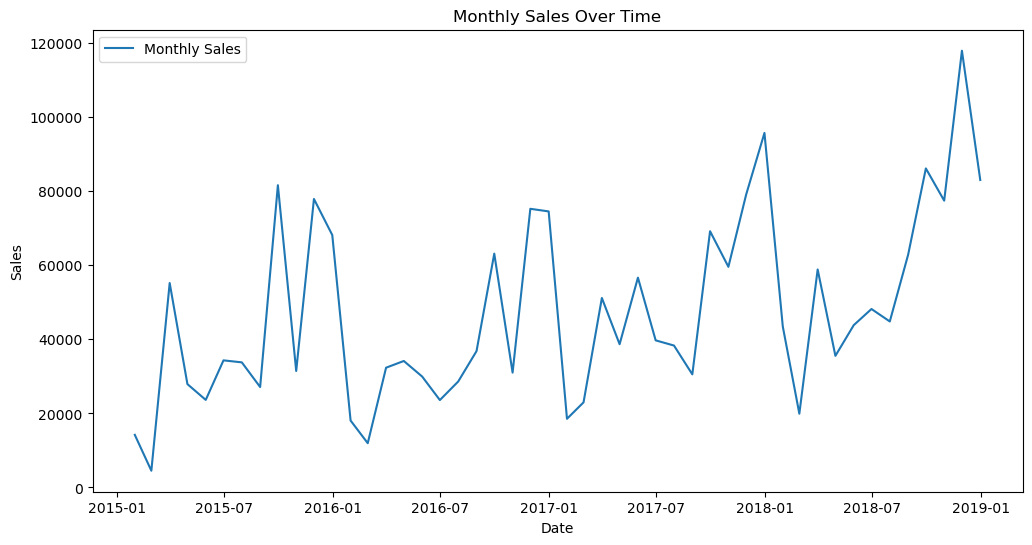

In [24]:
plt.figure(figsize = (12,6))
plt.plot(monthly_sales, label = "Monthly Sales")
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

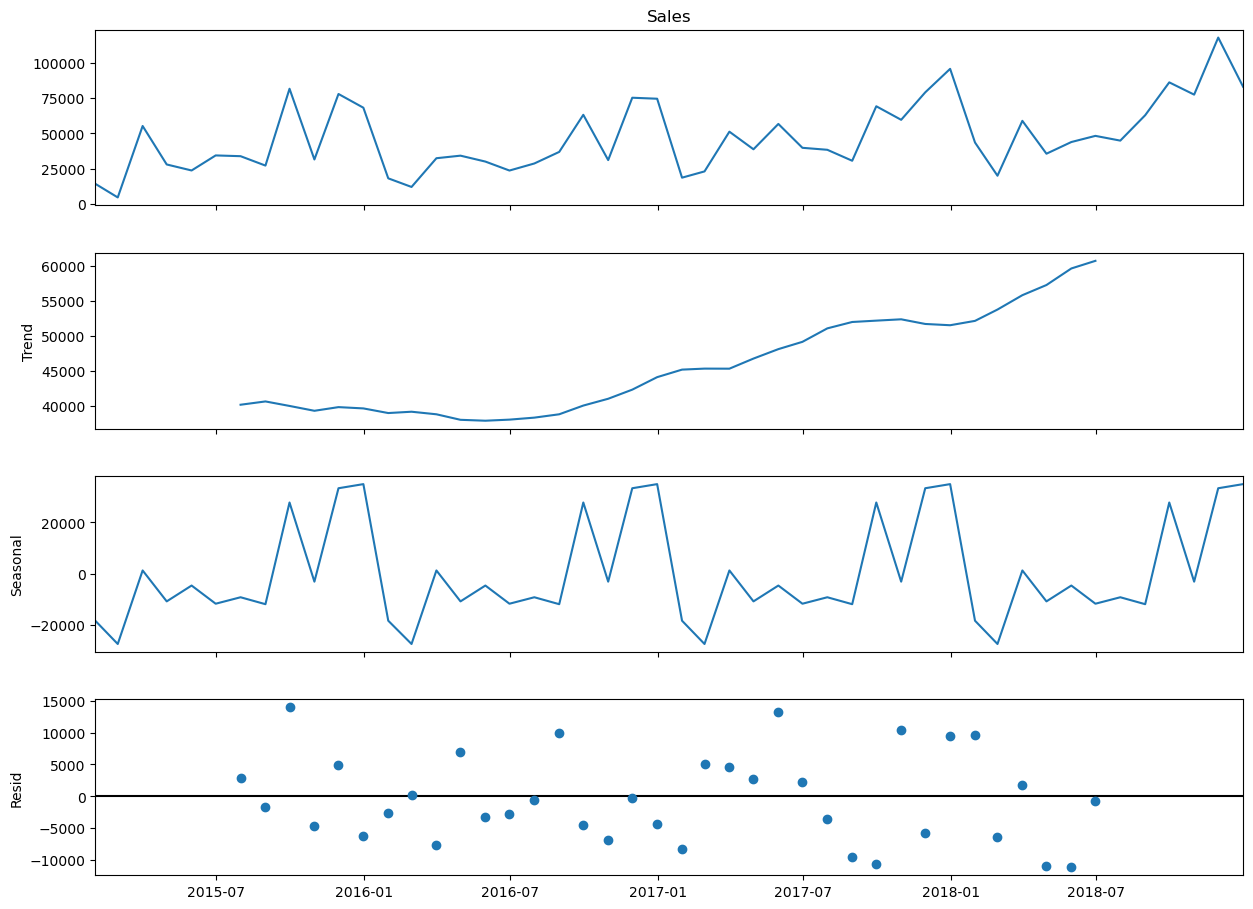

In [26]:
decomposition = seasonal_decompose(monthly_sales, model="additive", period=12)  # 12 months in a year
fig = decomposition.plot()
fig.set_size_inches(14, 10)

In [32]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test Results:')
    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    return result[1] < 0.05  # Returns True if p-value < 0.05 (stationary)

is_stationary = check_stationarity(monthly_sales)


print(f"\nTime series is {'stationary' if is_stationary else 'non-stationary'}")

Augmented Dickey-Fuller Test Results:
ADF Statistic:  -4.416136761430769
p-value:  0.00027791039276670623
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Time series is stationary


In [33]:
print("Stationary" if adfuller(monthly_sales)[1] < 0.05 else "Non-Stationary")

Stationary


In [34]:
auto_model = auto_arima(monthly_sales, start_p = 0, start_q = 0, max_p = 5, max_q = 5, m =12,
                        seasonal = True, d = None, trace = True, error_action = "ignore",
                        suppress_warnings = True, stepwise = True
                       )

C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\m

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1085.632, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1096.560, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1076.500, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1077.487, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1094.708, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1089.579, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1078.250, Time=0.08 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1078.452, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1080.901, Time=0.07 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1079.864, Time=0.27 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1084.035, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1073.635, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1087.151, Time=0.03 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1075.267, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1075.518, Time=0.13 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1078.501, Time=0.10 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1076.937, Time=0.36 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=1076.040, Time=0.11 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1076.285, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1076.328, Time=0.06 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=1078.253, Time=0.22 sec
 ARIMA(2,1,0)(1,0,0)[12]             : AIC=1071.915, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[12]             : AIC=1086.029, Time=0.03 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12]             : AIC=1073.387, Time=0.16 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=1073.425, Time=0.14 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12]             : AIC=1077.098, Time=0.08 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12]             : AIC=1075.363, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1074.570, Time=0.05 sec
 ARIMA(3,1,0)(1,0,0)[12]             : AIC=1074.296, Time=0.08 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12]             : AIC=1074.696, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12]             : AIC=1072.847, Time=0.09 sec


C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\manee\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12]             : AIC=1074.949, Time=0.20 sec

Best model:  ARIMA(2,1,0)(1,0,0)[12]          
Total fit time: 3.627 seconds


In [44]:
model = ARIMA(monthly_sales, order = auto_model.order, seasonal_order = auto_model.seasonal_order)
results = model.fit()
print(results)

In [45]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods) 
mean_forecast = forecast.predicted_mean

print(mean_forecast)

2019-01-31     71457.294750
2019-02-28     55170.675645
2019-03-31     75354.273325
2019-04-30     63712.967911
2019-05-31     68065.122532
2019-06-30     70562.386126
2019-07-31     68781.958274
2019-08-31     79738.550986
2019-09-30     94101.274961
2019-10-31     88767.503541
2019-11-30    113674.495453
2019-12-31     92191.072959
Freq: ME, Name: predicted_mean, dtype: float64


In [46]:
conf_int_95 = forecast.conf_int(alpha = 0.05)
conf_int_80 = forecast.conf_int(alpha = 0.20)
conf_int_70 = forecast.conf_int(alpha = 0.30)

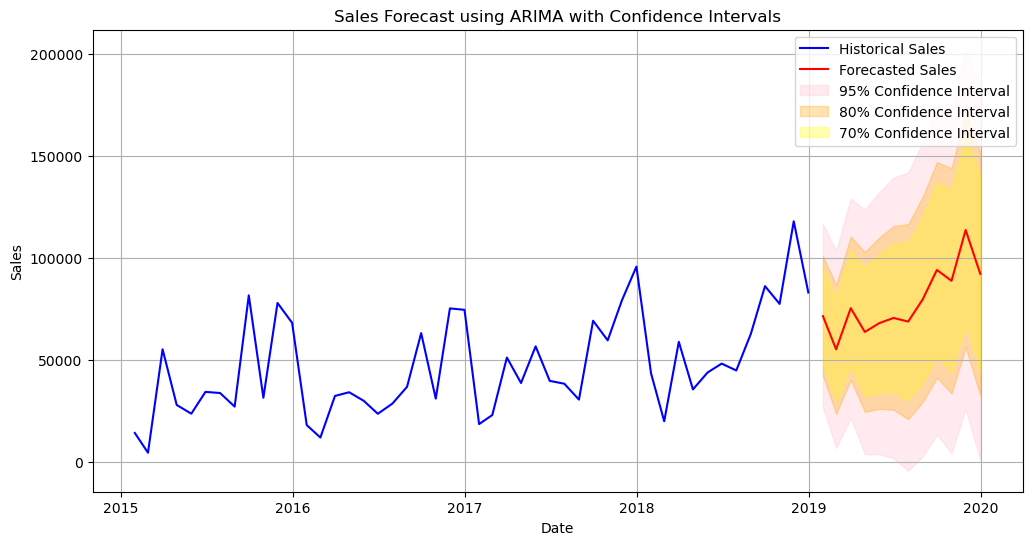

In [47]:

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales', color='blue')  # Actual data
plt.plot(mean_forecast, label='Forecasted Sales', color='red')  # Forecasted values

# Plot confidence intervals
plt.fill_between(mean_forecast.index, conf_int_95.iloc[:, 0], conf_int_95.iloc[:, 1], 
                 color='pink', alpha=0.3, label="95% Confidence Interval")
plt.fill_between(mean_forecast.index, conf_int_80.iloc[:, 0], conf_int_80.iloc[:, 1], 
                 color='orange', alpha=0.3, label="80% Confidence Interval")
plt.fill_between(mean_forecast.index, conf_int_70.iloc[:, 0], conf_int_70.iloc[:, 1], 
                 color='yellow', alpha=0.3, label="70% Confidence Interval")

# Labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast using ARIMA with Confidence Intervals')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [51]:
# Calculate error metrics
actual_values = monthly_sales[-forecast_periods:]  # Last 12 months as actual data
mse = mean_squared_error(actual_values, mean_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, mean_forecast)

# Print error metrics
print(f" Mean Squared Error (MSE): {mse:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" Mean Absolute Error (MAE): {mae:.2f}\n")

 Mean Squared Error (MSE): 444334729.22
 Root Mean Squared Error (RMSE): 21079.25
 Mean Absolute Error (MAE): 19004.41



In [52]:
forecast_df = pd.DataFrame({
    "Forecast": mean_forecast,
    "Lower_95%": conf_int_95.iloc[:, 0],
    "Upper_95%": conf_int_95.iloc[:, 1],
    "Lower_80%": conf_int_80.iloc[:, 0],
    "Upper_80%": conf_int_80.iloc[:, 1],
    "Lower_70%": conf_int_70.iloc[:, 0],
    "Upper_70%": conf_int_70.iloc[:, 1]
})

# Print the forecast table
print(" Detailed Forecast with Confidence Intervals:\n")
print(forecast_df)

 Detailed Forecast with Confidence Intervals:

                 Forecast     Lower_95%      Upper_95%     Lower_80%  \
2019-01-31   71457.294750  26519.448465  116395.141035  42074.016428   
2019-02-28   55170.675645   6856.399001  103484.952290  23579.668178   
2019-03-31   75354.273325  21594.176473  129114.370177  40202.435420   
2019-04-30   63712.967911   3787.033020  123638.902802  24529.505214   
2019-05-31   68065.122532   3753.333455  132376.911608  26013.903926   
2019-06-30   70562.386126   1722.863561  139401.908691  25550.641721   
2019-07-31   68781.958274  -4308.035990  141871.952537  20990.979810   
2019-08-31   79738.550986   2724.249353  156752.852618  29381.605856   
2019-09-30   94101.274961  13300.622927  174901.926996  41268.568377   
2019-10-31   88767.503541   4360.758285  173174.248797  33576.899337   
2019-11-30  113674.495453  25814.812917  201534.177988  56226.136917   
2019-12-31   92191.072959   1003.720927  183378.424992  32566.868292   

                

In [53]:
# Fit the Holt-Winters model
model_hw = ExponentialSmoothing(monthly_sales, 
                                trend="add", 
                                seasonal="add", 
                                seasonal_periods=12).fit()

# Forecast future values
forecast_periods = 12  # Forecast for next 12 months
forecast_hw = model_hw.forecast(steps=forecast_periods)

# Print Forecasted values
print(" Holt-Winters Forecast:\n")
print(forecast_hw)

 Holt-Winters Forecast:

2019-01-31     49848.408728
2019-02-28     42052.212826
2019-03-31     71932.475277
2019-04-30     61163.223076
2019-05-31     68587.748736
2019-06-30     62782.770453
2019-07-31     66559.478957
2019-08-31     65128.380229
2019-09-30    105950.513528
2019-10-31     76426.335859
2019-11-30    114029.837166
2019-12-31    116895.157705
Freq: ME, dtype: float64


C:\Users\manee\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [61]:
# Get actual values (excluding the forecast period)
actual_values = monthly_sales[-12:]  # Assuming last 12 months are test data
predicted_values = forecast_hw[:12]  # Corresponding forecast values

# Calculate evaluation metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print("Holt-Winters Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Holt-Winters Model Evaluation:
Mean Squared Error (MSE): 351369522.5802
Root Mean Squared Error (RMSE): 18744.8532
Mean Absolute Error (MAE): 15763.7291


In [70]:
model_hw_mul = ExponentialSmoothing(monthly_sales, 
                                    trend="mul", 
                                    seasonal="mul", 
                                    seasonal_periods=12).fit()

# Forecast future values
forecast_periods = 12  # Forecast for next 12 months
forecast_hw_mul = model_hw_mul.forecast(steps=forecast_periods)

# Print Forecasted values
print(" Holt-Winters Multiplicative Forecast:\n")
print(forecast_hw_mul)

 Holt-Winters Multiplicative Forecast:

2019-01-31    34018.734969
2019-02-28    23429.490826
2019-03-31    59450.515797
2019-04-30    45975.352077
2019-05-31    52678.690925
2019-06-30    43065.559099
2019-07-31    45055.443011
2019-08-31    42237.958477
2019-09-30    94221.503245
2019-10-31    51067.937020
2019-11-30    99219.200320
2019-12-31    98752.940215
Freq: ME, dtype: float64


C:\Users\manee\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [56]:
# Get actual values (excluding the forecast period)
actual_values = monthly_sales[-12:]  # Assuming last 12 months are test data
predicted_values = forecast_hw_mul[:12]  # Corresponding forecast values

# Calculate evaluation metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print("Holt-Winters Multiplicative Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Holt-Winters Multiplicative Model Evaluation:
Mean Squared Error (MSE): 174885095.7312
Root Mean Squared Error (RMSE): 13224.4129
Mean Absolute Error (MAE): 10640.4332


In [69]:
model_hw_fixed = ExponentialSmoothing(monthly_sales, 
                                      trend="mul", 
                                      seasonal="mul", 
                                      seasonal_periods=12).fit(
    smoothing_level=0.8,     # Alpha (Level smoothing)
    smoothing_trend=0.2,     # Beta (Trend smoothing)
    smoothing_seasonal=0.3   # Gamma (Seasonal smoothing)
)

# Forecast for the next 12 months
forecast_hw_fixed = model_hw_fixed.forecast(steps=12)

# Print forecasted values
print("\n Holt-Winters Fixed Parameter Forecast:\n")
print(forecast_hw_fixed)


 Holt-Winters Fixed Parameter Forecast:

2019-01-31    29783.704759
2019-02-28    18510.476880
2019-03-31    68970.012885
2019-04-30    51487.972556
2019-05-31    55977.674007
2019-06-30    42151.163572
2019-07-31    36239.191727
2019-08-31    39726.266542
2019-09-30    70888.599432
2019-10-31    52565.769471
2019-11-30    79506.495248
2019-12-31    90956.839512
Freq: ME, dtype: float64


C:\Users\manee\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [60]:
# Evaluate Model Performance
y_true = monthly_sales[-12:]  # Last 12 months actual data for evaluation
y_pred = forecast_hw_fixed[:12]  # Forecasted values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Model Evaluation:
Mean Squared Error (MSE): 310821360.78
Root Mean Squared Error (RMSE): 17630.13
Mean Absolute Error (MAE): 14795.79


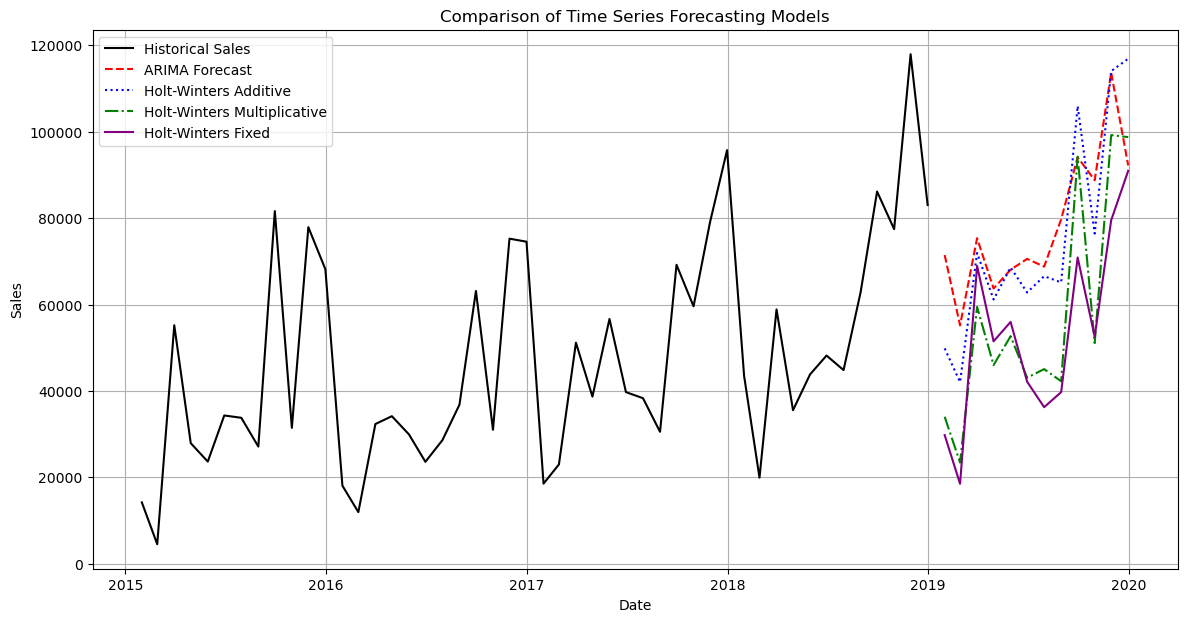

In [62]:
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(monthly_sales, label="Historical Sales", color="black", linestyle="-")

# Plot ARIMA forecast
plt.plot(mean_forecast, label="ARIMA Forecast", color="red", linestyle="dashed")

# Plot Holt-Winters Additive
plt.plot(forecast_hw, label="Holt-Winters Additive", color="blue", linestyle="dotted")

# Plot Holt-Winters Multiplicative
plt.plot(forecast_hw_mul, label="Holt-Winters Multiplicative", color="green", linestyle="dashdot")

# Plot Holt-Winters Fixed Parameter
plt.plot(forecast_hw_fixed, label="Holt-Winters Fixed", color="purple", linestyle="solid")

# Add Labels and Legends
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Time Series Forecasting Models')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [66]:
# Assigning error metrics for ARIMA
mse_arima = mean_squared_error(monthly_sales[-forecast_periods:], mean_forecast)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(monthly_sales[-forecast_periods:], mean_forecast)

# Assigning error metrics for Holt-Winters Additive
mse_hw_add = mean_squared_error(monthly_sales[-forecast_periods:], forecast_hw)
rmse_hw_add = np.sqrt(mse_hw_add)
mae_hw_add = mean_absolute_error(monthly_sales[-forecast_periods:], forecast_hw)

# Assigning error metrics for Holt-Winters Multiplicative
mse_hw_mul = mean_squared_error(monthly_sales[-forecast_periods:], forecast_hw_mul)
rmse_hw_mul = np.sqrt(mse_hw_mul)
mae_hw_mul = mean_absolute_error(monthly_sales[-forecast_periods:], forecast_hw_mul)

# Assigning error metrics for Holt-Winters Fixed Parameter Model
mse_hw_fixed = mean_squared_error(monthly_sales[-forecast_periods:], forecast_hw_fixed)
rmse_hw_fixed = np.sqrt(mse_hw_fixed)
mae_hw_fixed = mean_absolute_error(monthly_sales[-forecast_periods:], forecast_hw_fixed)

In [67]:
error_metrics = pd.DataFrame({
    "Model": ["ARIMA", "Holt-Winters Additive", "Holt-Winters Multiplicative", "Holt-Winters Fixed"],
    "MSE": [mse_arima, mse_hw_add, mse_hw_mul, mse_hw_fixed],
    "RMSE": [rmse_arima, rmse_hw_add, rmse_hw_mul, rmse_hw_fixed],
    "MAE": [mae_arima, mae_hw_add, mae_hw_mul, mae_hw_fixed]
})

print("\nModel Comparison Based on Error Metrics:")
print(error_metrics)


Model Comparison Based on Error Metrics:
                         Model           MSE          RMSE           MAE
0                        ARIMA  4.443347e+08  21079.248782  19004.406363
1        Holt-Winters Additive  3.513695e+08  18744.853229  15763.729141
2  Holt-Winters Multiplicative  1.748851e+08  13224.412869  10640.433234
3           Holt-Winters Fixed  3.108214e+08  17630.126511  14795.788561


In [ ]:
# Holt-Winters Multiplicative provides the most accurate forecast.